In [1]:

import numpy as np
import iris
import matplotlib.pyplot as plt
import time
import glob
from scipy import signal
import scipy
import scipy.stats
import statsmodels.api as sm
import running_mean_post as rmp
import cartopy.crs as ccrs
import iris.analysis.cartography
import numpy.ma as ma
import os
import running_mean as rm
import running_mean_post as rmp
from scipy.ndimage import gaussian_filter1d
import subprocess
import uuid
import numpy.ma as ma
import iris.plot as iplt
import matplotlib.cm as mpl_cm
import matplotlib.gridspec as gridspec
from scipy.ndimage import gaussian_filter1d
import scipy.stats as stats
import pandas
import iris.coord_categorisation
import iris.analysis
import iris.quickplot as qplt
import pickle
import iris.analysis.stats
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import ticker
from cdo import *
cdo = Cdo()



-->> Could not load xarray!! <<--


functions used later on

In [2]:

def model_names(directory,var):
	files = glob.glob(directory+'/*_'+var+'_*.nc')
	models_tmp = []
	for file in files:
		statinfo = os.stat(file)
		if statinfo.st_size >= 1:
			models_tmp.append(file.split('/')[-1].split('_')[0])
	models = np.unique(models_tmp)
	return models




def calculate_composites(models,var_name,my_dir,high_ice_years,low_ice_years,experiment,file_ending,lags):
	high_composite = np.zeros([np.size(models),180,360])
	high_composite[:] = np.NAN
	low_composite = np.zeros([np.size(models),180,360])
	low_composite[:] = np.NAN
	for i,model in enumerate(models):
		# try:
			print model
			c1 = iris.load_cube(my_dir + model+'_'+var_name+'_'+experiment+'*'+file_ending)
			iris.coord_categorisation.add_year(c1, 'time', name='year')
			years = c1.coord('year').points
			try:
				c1 = c1.aggregated_by('year', iris.analysis.MEAN)
			except:
				print ' '
			try:
				c1.coord('longitude').guess_bounds()
				c1.coord('latitude').guess_bounds()
			except:
				print 'cube already has bounds'
			# cube_data = c1.data
			# cube_data_detrended = scipy.signal.detrend(cube_data, axis=0)
			# c1.data = cube_data_detrended
			high_ice_indices = np.where(np.in1d(years, high_ice_years))[0]
			high_composite[i] = c1[high_ice_indices].collapsed('time',iris.analysis.MEAN).data
			low_ice_indices = np.where(np.in1d(years, low_ice_years))[0]
			low_composite[i] = c1[low_ice_indices].collapsed('time',iris.analysis.MEAN).data
		# except:
		# 	print 'failed'
	return [high_composite-low_composite]



def plot_prep(i,composites,c1):
	var_mean = np.nanmean(composites[i],axis=0)
	mean_var_cube = c1[0]
	tmp2 = np.ma.masked_array(var_mean)
	mean_var_cube.data = tmp2.data
	return mean_var_cube


def calculate_agreementII(run_composites,agreement):
    # run_composites=run_composites[lag]
    composites_agreement = run_composites[0].copy()
    composites_agreement[:] = 0.0
    for i in range(np.shape(run_composites)[1]):
        for j in range(np.shape(run_composites)[2]):
            tmp1 = run_composites[:,i,j]
            a = np.float(len(np.where(tmp1 > 0.0)[0]))
            b = np.float(len(np.where(tmp1 < 0.0)[0]))
            ratio = np.max([a/len(tmp1),b/len(tmp1)])
            # if b > 0.0:
            #     ratio = (a / b)
            #     # print 'ratio ',ratio
            if ratio > agreement:
                composites_agreement[i,j] = np.NAN
            if run_composites[:,i,j].all() == 0.0:
            	composites_agreement[i,j] = np.NAN
    return composites_agreement

In [5]:
# dir_amoc = '/data/NAS-ph290/ph290/cmip5/msftmyz/last1000/'
dir_psl = '/data/NAS-ph290/ph290/cmip5/last1000/'
dir_sos = '/data/NAS-ph290/ph290/cmip5/last1000/'
dir_tos = '/data/NAS-ph290/ph290/cmip5/last1000/'
dir_sic = '/data/NAS-ph290/ph290/cmip5/last1000/'
dir_pr = '/data/NAS-ph290/ph290/cmip5/last1000/'
dir_rhopot = dir_tos

In [6]:

###calc Density
calculate_the_densities=False

if calculate_the_densities:

	dir_psl = '/data/NAS-ph290/ph290/cmip5/last1000/'
	dir_sos = '/data/NAS-ph290/ph290/cmip5/last1000/'
	dir_tos = '/data/NAS-ph290/ph290/cmip5/last1000/'
	dir_sic = '/data/NAS-ph290/ph290/cmip5/last1000/'
	dir_pr = '/data/NAS-ph290/ph290/cmip5/last1000/'

	m0 = model_names(dir_sic,'sic')
	# m1 = model_names(dir_pr,'pr')
	m2 = model_names(dir_sos,'sos')
	# m2 = model_names(dir_sos,'sos')
	m1 = model_names(dir_tos,'tos')
	# m3 = model_names(dir_sic,'sic')
	# m4 = model_names(dir_amoc,'msftmyz')

	models = np.intersect1d(m0,m1)
	models = np.intersect1d(models,m2)
	# models = np.intersect1d(models,m3)
	# models = np.intersect1d(models,m4)

	models = list(models)
	try:
		models.remove('GISS-E2-R') # seaice does not load - problem with netcdf
		models.remove('HadCM3') # seaice does not load - problem with netcdf
		models.remove('HadGEM2-ES') #  not got density yet
	except:
		print 'none to remove'

	print models

	for model in models:
		try:
			subprocess.call(['rm /data/dataSSD0/ph290/tmp/delete.nc'], shell=True)
		except:
			pass
		try:
			subprocess.call(['rm /data/dataSSD0/ph290/tmp/delete_tos.nc'], shell=True)
		except:
			pass
		try:
			subprocess.call(['rm /data/dataSSD0/ph290/tmp/delete_sos.nc'], shell=True)
		except:
			pass
		try:
			subprocess.call(['rm /data/dataSSD0/ph290/tmp/delete_join.nc'], shell=True)
		except:
			pass
		cdo.setname('to', input = '-subc,273.15 '+dir_tos+model+'_tos_past1000_r1i1p1_regridded_not_vertically.nc', output = '/data/dataSSD0/ph290/tmp/delete_tos.nc',  options = '-P 7')
		cdo.setname('sao', input = dir_sos+model+'_sos_past1000_regridded.nc', output = '/data/dataSSD0/ph290/tmp/delete_sos.nc',  options = '-P 7')
		tmp = ' '.join(['/data/dataSSD0/ph290/tmp/delete_tos.nc','/data/dataSSD0/ph290/tmp/delete_sos.nc'])
		cdo.merge(input = tmp, output = '/data/dataSSD0/ph290/tmp/delete_join.nc',  options = '-P 7')
		cdo.rhopot(input = '/data/dataSSD0/ph290/tmp/delete_join.nc', output = dir_tos+model+'_rhopot_past1000_r1i1p1_regridded.nc',  options = '-P 7')
		try:
			subprocess.call(['rm /data/dataSSD0/ph290/tmp/delete.nc'], shell=True)
		except:
			pass
		try:
			subprocess.call(['rm /data/dataSSD0/ph290/tmp/delete_tos.nc'], shell=True)
		except:
			pass
		try:
			subprocess.call(['rm /data/dataSSD0/ph290/tmp/delete_sos.nc'], shell=True)
		except:
			pass
		try:
			subprocess.call(['rm /data/dataSSD0/ph290/tmp/delete_join.nc'], shell=True)
		except:
			pass



In [18]:
# cdo.setname('to', input = '-subc,273.15 '+dir_tos+model+'_tos_past1000_r1i1p1_regridded_not_vertically.nc', output = '/data/dataSSD0/ph290/tmp/delete_tos.nc',  options = '-P 7')
# cdo.setname('sao', input = dir_sos+model+'_sos_past1000_regridded.nc', output = '/data/dataSSD0/ph290/tmp/delete_sos.nc',  options = '-P 7')
# tmp = ' '.join(['/data/dataSSD0/ph290/tmp/delete_tos.nc','/data/dataSSD0/ph290/tmp/delete_sos.nc'])
# cdo.merge(input = tmp, output = '/data/dataSSD0/ph290/tmp/delete_join.nc',  options = '-P 7')
# cdo.rhopot(input = '/data/dataSSD0/ph290/tmp/delete_join.nc', output = dir_tos+model+'_rhopot_past1000_r1i1p1_regridded.nc',  options = '-P 7')

print 'having to do hadgem calculations manually on groupserv'
print 'cdo setname,to -subc,273.15 '+dir_tos+model+'_tos_past1000_r1i1p1_regridded_not_vertically.nc /data/BatCaveNAS/ph290/tmp/delete_tos.nc'
print 'cdo setname,sao '+dir_sos+model+'_sos_past1000_r1i1p1_regridded.nc /data/BatCaveNAS/ph290/tmp/delete_sos.nc'
tmp = ' '.join(['/data/BatCaveNAS/ph290/tmp/delete_tos.nc','/data/BatCaveNAS/ph290/tmp/delete_sos.nc'])
print 'cdo merge '+tmp+' /data/BatCaveNAS/ph290/tmp/delete_join.nc'
print 'cdo rhopot /data/BatCaveNAS/ph290/tmp/delete_join.nc '+dir_tos+model+'_rhopot_past1000_r1i1p1_regridded.nc'



cdo setname,to -subc,273.15 /data/NAS-ph290/ph290/cmip5/last1000/HadGEM2-ES_tos_past1000_r1i1p1_regridded_not_vertically.nc /data/BatCaveNAS/ph290/tmp/delete_tos.nc
cdo setname,sao /data/NAS-ph290/ph290/cmip5/last1000/HadGEM2-ES_sos_past1000_r1i1p1_regridded.nc /data/BatCaveNAS/ph290/tmp/delete_sos.nc
cdo merge /data/BatCaveNAS/ph290/tmp/delete_tos.nc /data/BatCaveNAS/ph290/tmp/delete_sos.nc /data/BatCaveNAS/ph290/tmp/delete_join.nc
cdo rhopot /data/BatCaveNAS/ph290/tmp/delete_join.nc /data/NAS-ph290/ph290/cmip5/last1000/HadGEM2-ES_rhopot_past1000_r1i1p1_regridded.nc


In [10]:



m0 = model_names(dir_sic,'sic')
# m1 = model_names(dir_pr,'pr')
m2 = model_names(dir_sos,'sos')
# m2 = model_names(dir_sos,'sos')
m1 = model_names(dir_tos,'tos')
m3 = model_names(dir_rhopot,'rhopot')
# m4 = model_names(dir_amoc,'msftmyz')

models = np.intersect1d(m0,m1)
models = np.intersect1d(models,m2)
models = np.intersect1d(models,m3)
# models = np.intersect1d(models,m4)

models = list(models)
try:
	models.remove('GISS-E2-R') # seaice does not load - problem with netcdf
	models.remove('HadCM3') # seaice does not load - problem with netcdf
	# models.remove('HadGEM2-ES') #  not got density yet
except:
	print 'none to remove'

print models


import pandas as pd
df = pd.read_csv('/data/NAS-geo01/ph290/observations/iceland_timeseries.csv')
sea_ice_years = df['seaice_year'].values
sea_ice_extent = df['seaice'].values


high_ice_years = sea_ice_years[np.where(sea_ice_extent > 1)]
low_ice_years = sea_ice_years[np.where(sea_ice_extent < -1)]

df1 = pd.read_csv('/data/NAS-geo01/ph290/misc_data/last_millenium_volcanic/IVI2TotalInjection_501-2000Version2.txt',skiprows=15,delim_whitespace=True,names=['year','nh','sh','nh_and_sh'])
years_to_avoid_tmp = df1.query('nh_and_sh > 15.0')['year'].values

years_to_avoid=[]

#volcanic years + the followinh 10 years
for y in years_to_avoid_tmp:
	for i in range(10):
		years_to_avoid.append(y+i)

years_to_avoid = np.unique(years_to_avoid)

#remove volcanic years +x from high and low ice years
high_ice_years = [x for x in high_ice_years if x not in years_to_avoid]
low_ice_years = [x for x in low_ice_years if x not in years_to_avoid]

# high_ice_years = sea_ice_years[np.where(sea_ice_extent > 1.0)]
# low_ice_years = sea_ice_years[np.where(sea_ice_extent < -1.0)]

# with open('/home/ph290/Documents/python_scripts/pickles/sic_psl.pickle', 'r') as f:
#     [correlations_pr,correlations_psl] = pickle.load(f)


# with open('/home/ph290/Documents/python_scripts/pickles/sic_stuff.pickle', 'r') as f:
#     [correlations_pr,correlations_amo] = pickle.load(f)



lags=[0]
var_name = 'sic'
run_composites_sic = calculate_composites(models,var_name,dir_sic,high_ice_years,low_ice_years,'past1000','regridded.nc',lags)
# var_name = 'pr'
# run_composites_pr = calculate_composites(models,var_name,dir_sic,high_ice_years,low_ice_years,'past1000','regridded_*_Amon.nc',lags)
var_name = 'sos'
run_composites_sos = calculate_composites(models,var_name,dir_sos,high_ice_years,low_ice_years,'past1000','regridded*.nc',lags)
var_name = 'tos'
run_composites_tos = calculate_composites(models,var_name,dir_tos,high_ice_years,low_ice_years,'past1000','regridded*.nc',lags)
var_name = 'rhopot'
run_composites_rhopot = calculate_composites(models,var_name,dir_rhopot,high_ice_years,low_ice_years,'past1000','regridded*.nc',lags)
# var_name = 'psl'
# run_composites_psl = calculate_composites(models,var_name,dir_psl,high_ice_years,low_ice_years,'past1000','regridded*.nc',lags)
# run_composites_rhopot = calculate_composites_density(models,high_ice_years,low_ice_years,lags)

# with open('/home/ph290/Documents/python_scripts/pickles/sic_psl.pickle', 'w') as f:
#     pickle.dump([correlations_pr,correlations_psl], f)
# with open('/home/ph290/Documents/python_scripts/pickles/sic_stuff.pickle', 'w') as f:
#     pickle.dump([control_run_correlations_pr,control_run_correlations_sic], f)



agreement=0.66
var_name = 'sic'
c1 = iris.load_cube(dir_sic + models[0]+'_'+var_name+'_'+'past1000'+'*regridded.nc')
composites_sic_agreement = calculate_agreement(run_composites_sic[0],agreement)
# c1 = iris.load_cube(dir_sic + models[0]+'_'+'pr'+'_'+'past1000'+'*not_vertically_Amon.nc')
# composites_pr_agreement = calculate_agreement(run_composites_pr[0],agreement)
c1 = iris.load_cube(dir_sic + models[0]+'_'+'sos'+'_'+'past1000'+'*regridded.nc')
composites_sos_agreement = calculate_agreement(run_composites_sos[0],agreement)
c1 = iris.load_cube(dir_tos + models[0]+'_'+'tos'+'_'+'past1000'+'*regridded_not_vertically.nc')
composites_tos_agreement = calculate_agreement(run_composites_tos[0],agreement)
c1 = iris.load_cube(dir_rhopot + models[0]+'_'+'rhopot'+'_'+'past1000'+'*regridded.nc')
composites_rhopot_agreement = calculate_agreement(run_composites_rhopot[0],agreement)
# c1 = iris.load_cube(dir_psl + models[0]+'_'+'psl'+'_'+'past1000'+'*regridded.nc')
# composites_psl_agreement = calculate_agreement(run_composites_psl[0],agreement)
# c1 = iris.load_cube('/data/NAS-ph290/ph290/cmip5/last1000/bcc-csm1-1_mixed_layer_density_r1i1p1.nc')
# composites_rhopot_agreement = calculate_agreement(run_composites_rhopot[0],agreement)

print 'refresh this by running cmip5_stm_func_II.py'


with open('/home/ph290/Documents/python_scripts/pickles/amoc_sections.pickle', 'r') as f:
    [models,strm_fun,max_strm_fun,max_strm_fun_26,max_strm_fun_45,model_years,mask1,files,resolution,model_meta] = pickle.load(f)


with open('/home/ph290/Documents/python_scripts/pickles/amoc_sectionsII.pickle', 'r') as f:
    [models,regridded_array] = pickle.load(f)


from gridfill import fill
from scipy.interpolate import RectBivariateSpline


depths_for_interpolation = [5.00000000e+00, 1.50000000e+01, 2.50000000e+01, 3.50000000e+01,
       4.50000000e+01, 5.50000000e+01, 6.50000000e+01, 7.50000000e+01,
       8.50000000e+01, 9.50000000e+01, 1.05000000e+02, 1.15000000e+02,
       1.25000000e+02, 1.35000000e+02, 1.45000000e+02, 1.55000000e+02,
       1.65098389e+02, 1.75479004e+02, 1.86291306e+02, 1.97660294e+02,
       2.09711395e+02, 2.22578293e+02, 2.36408798e+02, 2.51370193e+02,
       2.67654205e+02, 2.85483673e+02, 3.05119202e+02, 3.26868011e+02,
       3.51093506e+02, 3.78227600e+02, 4.08784607e+02, 4.43377686e+02,
       4.82736694e+02, 5.27727966e+02, 5.79372864e+02, 6.38862610e+02,
       7.07563293e+02, 7.87002502e+02, 8.78825195e+02, 9.84705933e+02,
       1.10620398e+03, 1.24456702e+03, 1.40049695e+03, 1.57394592e+03,
       1.76400293e+03, 1.96894397e+03, 2.18645703e+03, 2.41397192e+03,
       2.64900098e+03, 2.88938501e+03, 3.13340503e+03, 3.37979297e+03,
       3.62766992e+03, 3.87645190e+03, 4.12576807e+03, 4.37539160e+03,
       4.62518994e+03, 4.87508301e+03, 5.12502783e+03, 5.37500000e+03]




# import pandas as pd
# df = pd.read_csv('/data/NAS-geo01/ph290/observations/iceland_timeseries.csv')
# sea_ice_years = df['seaice_year'].values
# sea_ice_extent = df['seaice'].values


# high_ice_years = sea_ice_years[np.where(sea_ice_extent > 1.0)]
# low_ice_years = sea_ice_years[np.where(sea_ice_extent < -1.0)]



### calculate those multi-model mean composites ###

masked_array = np.ma.masked_invalid(regridded_array).copy()
regridded_array = np.nan_to_num(regridded_array).copy()

high_composite = np.ma.masked_array(np.zeros([np.size(models),len(depths_for_interpolation),180]))
high_composite[:] = np.NAN
low_composite = np.ma.masked_array(np.zeros([np.size(models),len(depths_for_interpolation),180]))
low_composite[:] = np.NAN
for i,model in enumerate(models):
# i=0
# model = models[i]
	# try:
    print model
    years = model_meta[model]['years']
    # data_detrended = scipy.signal.detrend(regridded_array[i], axis=0)
    # high_ice_indices = np.where(np.in1d(years, high_ice_years))[0]
    # high_composite[i] = np.mean(data_detrended[high_ice_indices],axis=0)
    # low_ice_indices = np.where(np.in1d(years, low_ice_years))[0]
    # low_composite[i] = np.mean(data_detrended[low_ice_indices],axis=0)
    high_ice_indices = np.where(np.in1d(years, high_ice_years))[0]
    high_composite[i] = np.mean(regridded_array[i][high_ice_indices],axis=0)
    high_composite[i] /= np.std(high_composite[i])
    low_ice_indices = np.where(np.in1d(years, low_ice_years))[0]
    low_composite[i] = np.mean(regridded_array[i][low_ice_indices],axis=0)
    low_composite[i] /= np.std(low_composite[i][:,90:180])



low_composite.mask = masked_array[0][0:np.shape(low_composite)[0]].mask
high_composite.mask = masked_array[0][0:np.shape(high_composite)[0]].mask




agreement=0.66
high_minus_low_composite_agreement = calculate_agreementII(high_composite-low_composite,agreement)
high_minus_low_composite_agreement.mask = masked_array[0][0].mask







none to remove
['CCSM4', 'CSIRO-Mk3L-1-2', 'HadGEM2-ES', 'MIROC-ESM', 'MPI-ESM-P', 'MRI-CGCM3', 'bcc-csm1-1']
CCSM4


/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'time'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'year'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'time'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'year'.
  warnings.warn(msg.format(self.name()))


CSIRO-Mk3L-1-2


/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'time'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'year'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'time'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'year'.
  warnings.warn(msg.format(self.name()))


HadGEM2-ES


/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'time'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'year'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'time'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'year'.
  warnings.warn(msg.format(self.name()))


MIROC-ESM


/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'time'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'year'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'time'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'year'.
  warnings.warn(msg.format(self.name()))


MPI-ESM-P


/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'time'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'year'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'time'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'year'.
  warnings.warn(msg.format(self.name()))


MRI-CGCM3


/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'time'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'year'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'time'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'year'.
  warnings.warn(msg.format(self.name()))


bcc-csm1-1


/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'time'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'year'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'time'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'year'.
  warnings.warn(msg.format(self.name()))


CCSM4


/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'time'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'year'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'time'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'year'.
  warnings.warn(msg.format(self.name()))


CSIRO-Mk3L-1-2


/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'time'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'year'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'time'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'year'.
  warnings.warn(msg.format(self.name()))


HadGEM2-ES


/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'time'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'year'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'time'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'year'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1935: UserWarning: Ignorin

MIROC-ESM


/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'time'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'year'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'time'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'year'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1935: UserWarning: Ignorin

MPI-ESM-P


/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'time'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'year'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'time'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'year'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1935: UserWarning: Ignorin

MRI-CGCM3


/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'time'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'year'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'time'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'year'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1935: UserWarning: Ignorin

bcc-csm1-1


/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'time'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'year'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'time'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'year'.
  warnings.warn(msg.format(self.name()))


CCSM4


/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'time'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'year'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'time'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'year'.
  warnings.warn(msg.format(self.name()))


CSIRO-Mk3L-1-2


/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'time'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'year'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'time'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'year'.
  warnings.warn(msg.format(self.name()))


HadGEM2-ES


/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'time'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'year'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'time'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'year'.
  warnings.warn(msg.format(self.name()))


MIROC-ESM


/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'time'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'year'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'time'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'year'.
  warnings.warn(msg.format(self.name()))


MPI-ESM-P


/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'time'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'year'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'time'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'year'.
  warnings.warn(msg.format(self.name()))


MRI-CGCM3


/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'time'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'year'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'time'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'year'.
  warnings.warn(msg.format(self.name()))


bcc-csm1-1


/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'time'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'year'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'time'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'year'.
  warnings.warn(msg.format(self.name()))


CCSM4


/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'time'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'year'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'time'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'year'.
  warnings.warn(msg.format(self.name()))


CSIRO-Mk3L-1-2


/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'time'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'year'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'time'.
  warnings.warn(msg.format(self.name()))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'year'.
  warnings.warn(msg.format(self.name()))


HadGEM2-ES


IndexError: Cannot index with zero length slice.

In [23]:
model = 'HadGEM2-ES'
var_name = 'rhopot'
print dir_rhopot
c1 = iris.load_cube(dir_rhopot + model+'_'+var_name+'_'+'past1000'+'*'+'regridded*.nc')
print c1
c2 = iris.load_cube('/data/NAS-ph290/ph290/cmip5/last1000/MPI-ESM-P_rhopot_past1000_r1i1p1_regridded.nc')
print c2

/data/NAS-ph290/ph290/cmip5/last1000/
sea_water_potential_density / (kg m-3) (time: 1; latitude: 180; longitude: 360)
     Dimension coordinates:
          time                              x            -               -
          latitude                          -            x               -
          longitude                         -            -               x
     Scalar coordinates:
          depth: 5.0 m, bound=(0.0, 10.0) m
     Attributes:
          CDI: Climate Data Interface version 1.9.5 (http://mpimet.mpg.de/cdi)
          CDO: Climate Data Operators version 1.9.5 (http://mpimet.mpg.de/cdo)
          Conventions: CF-1.6
          code: 18
          history: Tue Mar 19 09:27:28 2019: cdo rhopot delete_join.nc /data/NAS-ph290/ph290/cmip5/last1000/HadGEM2-ES_rhopot_past1000_r1i1p1_regridded.nc
Tue...
sea_water_potential_density / (kg m-3) (time: 1000; latitude: 180; longitude: 360)
     Dimension coordinates:
          time                              x               -  

In [16]:
model = 'HadGEM2-ES'
var_name = 'rhopot'
run_composites_rhopot = calculate_composites([model],var_name,dir_rhopot,high_ice_years,low_ice_years,'past1000','regridded*.nc',lags)


HadGEM2-ES


IndexError: Cannot index with zero length slice.

NameError: name 'composites_sic_agreement' is not defined

/home/ph290/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ph290/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ph290/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ph290/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ph290/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font famil

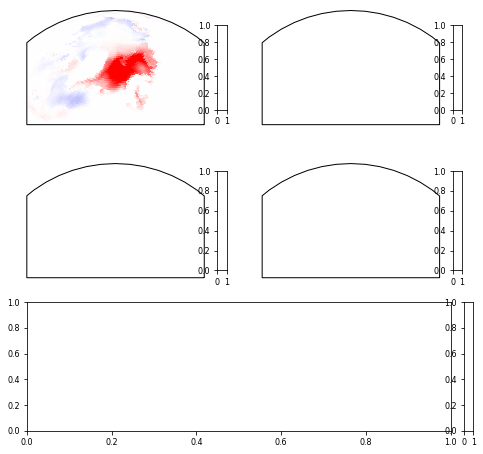

In [11]:
# c1 = iris.load_cube(dir_rhopot + models[0]+'_'+'rhopot'+'_'+'past1000'+'*regridded.nc')

minv = -2.5
maxv= 2.5
levs=51

##################################
# plotting                       #
##################################

daysec=60.0*60*24
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])

# plt.close('all')
# plt.figure(figsize=(10,10))
# # my_projection = ccrs.PlateCarree()
# # my_projection = ccrs.NorthPolarStereo()
# # my_projection = ccrs.NearsidePerspective(central_longitude=-10,central_latitude=60, satellite_height=15785831)
# # my_projection = ccrs.RotatedPole(pole_longitude=177.5, pole_latitude=45.0)
my_projection = ccrs.Orthographic(central_longitude=0.0, central_latitude=40.0, globe=None)
my_extent = [-180, 180, 50, 90]

plt.close('all')
plt.figure(figsize=(8,8))
# gs = gridspec.GridSpec(23, 40)
# ax1 = plt.subplot(gs[0:6,0:38],projection= my_projection)
# ax1b = plt.subplot(gs[0:6, 39])
# ax3 = plt.subplot(gs[8:14,0:38],projection= my_projection)
# ax3b = plt.subplot(gs[8:14, 39])
# ax4 = plt.subplot(gs[16:22,0:38])
# ax4b = plt.subplot(gs[16:22, 39])

# gs = gridspec.GridSpec(15, 80)
# ax1 = plt.subplot(gs[0:6,0:16],projection= my_projection)
# ax1b = plt.subplot(gs[0:6, 16])
# ax2 = plt.subplot(gs[0:6,21:37],projection= my_projection)
# ax2b = plt.subplot(gs[0:6, 37])
# ax3 = plt.subplot(gs[0:6,42:57],projection= my_projection)
# ax3b = plt.subplot(gs[0:6, 57])
# ax4 = plt.subplot(gs[0:6,62:77],projection= my_projection)
# ax4b = plt.subplot(gs[0:6, 77])
# ax_amoc = plt.subplot(gs[8:14,0:58])
# ax_amocb = plt.subplot(gs[8:14, 59])

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 8}
import matplotlib
matplotlib.rc('font', **font)

top=1
lev1a=9
lev1b=11
lev2a=20
lev2b=21
bottom = 30

gs = gridspec.GridSpec(30, 40)
ax1 = plt.subplot(gs[top:lev1a,0:16],projection= my_projection)
ax1b = plt.subplot(gs[top+1:lev1a-1, 17])
ax2 = plt.subplot(gs[top:lev1a,21:37],projection= my_projection)
ax2b = plt.subplot(gs[top+1:lev1a-1, 38])
ax3 = plt.subplot(gs[lev1b:lev2a,0:16],projection= my_projection)
ax3b = plt.subplot(gs[lev1b+1:lev2a-1, 17])
ax4 = plt.subplot(gs[lev1b:lev2a,21:37],projection= my_projection)
ax4b = plt.subplot(gs[lev1b+1:lev2a-1, 38])
ax_amoc = plt.subplot(gs[lev2b:bottom,0:38])
ax_amocb = plt.subplot(gs[lev2b:bottom, 39])

ax1.set_extent(my_extent, crs=ccrs.PlateCarree())
ax2.set_extent(my_extent, crs=ccrs.PlateCarree())
ax3.set_extent(my_extent, crs=ccrs.PlateCarree())
ax4.set_extent(my_extent, crs=ccrs.PlateCarree())

# ax1.set_global()
# ax2.set_global()
# ax3.set_global()
# ax4.set_global()


## sea-ice ##



# ax.set_global()

cube1 = plot_prep(0,run_composites_sic,c1)
lats1 = cube1.coord('latitude').points
lons1 = cube1.coord('longitude').points
data1 = cube1.data


contour_result1 = ax1.pcolormesh(lons1, lats1, data1,vmin=-5.0,vmax=5.0,
			transform=ccrs.PlateCarree(),cmap='bwr')
contour_result2 = ax1.pcolormesh(lons1, lats1, composites_sic_agreement,
			transform=ccrs.PlateCarree(),cmap='gray',vmin=0,vmax=1,alpha=0.1)

cb = plt.colorbar(contour_result1,cax=ax1b, orientation='vertical',extend='both')
tick_locator = ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator
cb.update_ticks()
cb.set_label('')
coast_50m = cfeature.NaturalEarthFeature('physical', 'coastline', '50m',facecolor='none')
ax1.add_feature(land_50m,facecolor='#F5F5F5')
ax1.add_feature(coast_50m,edgecolor='#000000',lw=0.5)
ax1.set_title('sea-ice percent\nhigh minus low sea-ice extent years')




## temperature ##

# ax2 = plt.subplot2grid((3, 1), (2, 0),projection= my_projection)


cube1 = plot_prep(0,run_composites_tos,c1)
lats1 = cube1.coord('latitude').points
lons1 = cube1.coord('longitude').points
data1 = cube1.data


contour_result1 = ax2.pcolormesh(lons1, lats1, data1,vmin=-0.5,vmax=0.5,
			transform=ccrs.PlateCarree(),cmap='bwr')
contour_result2 = ax2.pcolormesh(lons1, lats1, composites_tos_agreement,
			transform=ccrs.PlateCarree(),cmap='gray',vmin=0,vmax=1,alpha=0.1)

cb = plt.colorbar(contour_result1, cax=ax2b,orientation='vertical',extend='both')
tick_locator = ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator
cb.update_ticks()
cb.set_label('$^{\circ}$C')
ax2.add_feature(land_50m,facecolor='#F5F5F5')
ax2.add_feature(coast_50m,edgecolor='#000000',lw=0.5)
ax2.set_title('sst\nhigh minus low sea-ice extent years')

## psl ##


#
# cube1 = plot_prep(0,run_composites_psl,c1)
# lats1 = cube1.coord('latitude').points
# lons1 = cube1.coord('longitude').points
# data1 = cube1.data
#
#
# contour_result1 = ax3.pcolormesh(lons1, lats1, data1,vmin=-100.0,vmax=100.0,
# 			transform=ccrs.PlateCarree(),cmap='bwr')
# # contour_result2 = ax3.pcolormesh(lons1, lats1, composites_sos_agreement,
# # 			transform=ccrs.PlateCarree(),cmap='gray',vmin=0,vmax=1,alpha=0.1)
#
# cb = plt.colorbar(contour_result1, cax=ax3b,orientation='vertical',extend='both')
# tick_locator = ticker.MaxNLocator(nbins=5)
# cb.locator = tick_locator
# cb.update_ticks()
# cb.set_label(' ')
# ax3.add_feature(land_50m,facecolor='#F5F5F5')
# ax3.add_feature(coast_50m,edgecolor='#000000',lw=0.5)
# ax3.set_title('psl\nhigh minus low sea-ice extent years')


## salinity ##



cube1 = plot_prep(0,run_composites_sos,c1)
lats1 = cube1.coord('latitude').points
lons1 = cube1.coord('longitude').points
data1 = cube1.data


contour_result1 = ax3.pcolormesh(lons1, lats1, data1,vmin=-0.2,vmax=0.2,
			transform=ccrs.PlateCarree(),cmap='bwr')
contour_result2 = ax3.pcolormesh(lons1, lats1, composites_sos_agreement,
			transform=ccrs.PlateCarree(),cmap='gray',vmin=0,vmax=1,alpha=0.1)

cb = plt.colorbar(contour_result1, cax=ax3b,orientation='vertical',extend='both')
tick_locator = ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator
cb.update_ticks()
cb.set_label('g.kg$^{-1}$')
ax3.add_feature(land_50m,facecolor='#F5F5F5')
ax3.add_feature(coast_50m,edgecolor='#000000',lw=0.5)
ax3.set_title('surface salinity\nhigh minus low sea-ice extent years')

## density ##



cube1 = plot_prep(0,run_composites_rhopot,c1)
lats1 = cube1.coord('latitude').points
lons1 = cube1.coord('longitude').points
data1 = cube1.data


contour_result1 = ax4.pcolormesh(lons1, lats1, data1,vmin=-0.1,vmax=0.1,
			transform=ccrs.PlateCarree(),cmap='bwr')
contour_result2 = ax4.pcolormesh(lons1, lats1, composites_rhopot_agreement,
			transform=ccrs.PlateCarree(),cmap='gray',vmin=0,vmax=1,alpha=0.1)

cb = plt.colorbar(contour_result1, cax=ax4b,orientation='vertical',extend='both')
tick_locator = ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator
cb.update_ticks()
cb.set_label('kg m$^{-3}$')
ax4.add_feature(land_50m,facecolor='#F5F5F5')
ax4.add_feature(coast_50m,edgecolor='#000000',lw=0.5)
ax4.set_title('surface density\nhigh minus low sea-ice extent years')

## density ##


#
#
# cube1 = plot_prep(0,run_composites_rhopot,c1)
# lats1 = cube1.coord('latitude').points
# lons1 = cube1.coord('longitude').points
# data1 = cube1.data
#
#
# contour_result1 = ax5.pcolormesh(lons1, lats1, data1,vmin=-0.1,vmax=0.1,
# 			transform=ccrs.PlateCarree(),cmap='bwr')
# contour_result2 = ax5.pcolormesh(lons1, lats1, composites_rhopot_agreement,
# 			transform=ccrs.PlateCarree(),cmap='gray',vmin=0,vmax=1,alpha=0.1)
#
# cb = plt.colorbar(contour_result1, cax=ax5b,orientation='vertical',extend='both')
# tick_locator = ticker.MaxNLocator(nbins=5)
# cb.locator = tick_locator
# cb.update_ticks()
# cb.set_label('g.kg$^{-1}$')
# ax5.add_feature(land_50m,facecolor='#F5F5F5')
# ax5.add_feature(coast_50m,edgecolor='#000000',lw=0.5)
# ax5.set_title('surface density\nhigh minus low sea-ice extent years')

### AMOC ###

c4=ax_amoc.contourf(model_meta[models[0]]['lats'],depths_for_interpolation,np.ma.mean(high_composite,axis=0)-np.ma.mean(low_composite,axis=0),np.linspace(minv,maxv,levs),extend='both',cmap='bwr')
c4b=ax_amoc.contour(model_meta[models[0]]['lats'],depths_for_interpolation,np.ma.mean(high_composite,axis=0)-np.ma.mean(low_composite,axis=0), np.linspace(-1.0,1.0,11),colors='k',linewidths=0.2)
ax_amoc.clabel(c4b, c4b.levels, inline=True, fontsize=10,fmt='%1.1f')
agreement_result1 = ax_amoc.pcolormesh(model_meta[models[0]]['lats'],depths_for_interpolation, high_minus_low_composite_agreement,cmap='gray',vmin=0,vmax=1,alpha=0.1)
ax_amoc.set_title('multi-model mean normalised AMOC strength difference in high minus low sea-ice years')
ax_amoc.set_ylim([6000,0])
ax_amoc.set_xlim([0,60])
ax_amoc.set_ylabel('depth (m)')
ax_amoc.set_xlabel('latitude $^{\circ}$N')
cb4 = plt.colorbar(c4, cax=ax_amocb,orientation='vertical')


############
plt.savefig('/home/ph290/Documents/figures/stuff_high_v_low_ice_sst_removing_vbolc_years_plus9.png')

plt.show(block=False)
